## Baseline Detector Evaluation (Merchant)

Evaluate the simple threshold rule for detecting velocity spikes in the sparkov + synthetic spikes dataset, then check against the real world Caixa data.

### Method

 - Count number of unique cards per merchant in 30s buckets
 - Raise a flag if the count is greater than the set threshold
 - Compare predictions to the ground truth - MERCHANT_SET (pairs of merchant_id, bucket_30s)

 Use per bucket, not per transaction, to avoid over counting. Bucket is flagged once whether 10 or 100 transactions in 30s window.

### Streamed Data Evaluation

Stream the dataset once through, update the per merchant unique card count on each Tx, flag bucket once the count is greater than the threshold, calculate confusion matrix based on all merchant/bucket pairs. This mirrors what the Raspberry Pi will do on live card taps.

In [65]:
import sys
import os
import pandas as pd

#create absoulute path to notebook's. parent directory to src
module_path = os.path.abspath(os.path.join('..', 'src'))
#add to sys.path if not already there
if module_path not in sys.path:
    sys.path.append(module_path)

#import detector wrapper functions
from baseline_detector import MerchantBaseline, CardBaseline
#import the merchant and card sets from truth tables
from truth_tables import MERCHANT_SET, CARD_SET
#inport evaluation helper functions
from eval_funcs import threshold_predictions, per_bucket_confusion, precision_recall_f1, sweep_thresholds

#ensure constistent d types
DTYPES = {"merchant_id": str, "card_id": str, "zip": str}

In [66]:
# #read in spiked dataset, parsing timestamp as a time object, setting merchant and card ids to strings
# #set low memory false to avoid incorrect data type inferences
df = pd.read_csv(
    "../data/processed/sparkov_spikes.csv",
    parse_dates=["timestamp"],
    dtype=DTYPES,
    low_memory=False
)

#define initial merchant spike baseline
THRESHOLD_M = 6

# #create instance of merchant baseline class
mb = MerchantBaseline(threshold=THRESHOLD_M)

#create empty sets for predictions and coverage
predicted = set() #set of (merchant_id, bucket) that we flag
all_buckets = set() #set of all (merchant_id, buckets) streamed in

for row in df.itertuples():
    #call the baseline wrapper class' update function
    flag, info = mb.update(row.merchant_id, row.timestamp, row.card_id)
    bucket = info["bucket"]
    #add each to the all bucekts set
    all_buckets.add((row.merchant_id, bucket))
    #add to flagged set if over threshold
    if flag:
        predicted.add((row.merchant_id, bucket))

#find confusion matrix
cm = per_bucket_confusion(predicted, MERCHANT_SET, all_buckets)
#calc precision, recall, and f1 scores
m  = precision_recall_f1(cm["tp"], cm["fp"], cm["fn"])

#print results
print(f"TP {cm['tp']} FP {cm['fp']} FN {cm['fn']} TN {cm['tn']}")
print(f"precision {m['precision']:.3f} recall {m['recall']:.3f} F1 {m['f1']:.3f}")

TP 50 FP 0 FN 0 TN 1555392
precision 1.000 recall 1.000 F1 1.000


### Varied Threshold Test

Compute the unique cards per mechant/bucket once, then sweep through different thresholds 2-8, calculate and compare precision/recall against the ground truth. Choose the smallest threshold that gives perfect or near perfect recall on the synthetic data and will likely stay quiet on real data such as the Caixa dataset

In [68]:
#add a bucket column to the dataframe (flooring same as detector/truth table)
df["bucket"] = df["timestamp"].dt.floor("30s")

#count unique cards per merchant
counts_m = df.groupby(["merchant_id", "bucket"])["card_id"].nunique()
#convert to a dictionary of key: (merchant, bucket), value: count or unique cards
counts_m_dict = {k: int(v) for k, v in counts_m.items()}
#all merchant/bucket pairs (used to find number of true negatives)
all_buckets = set(counts_m_dict.keys())

results = sweep_thresholds(counts_m_dict, MERCHANT_SET, all_buckets, start=2, stop=8)
for r in results:
    print(r)

print("truth merchant spikes:", len(MERCHANT_SET))
print("merchant-buckets total:", counts_m.size)

{'th': 2, 'tp': 50, 'fp': 2297, 'fn': 0, 'tn': 1553095, 'precision': 0.021303792074989347, 'recall': 1.0, 'f1': 0.04171881518564872}
{'th': 3, 'tp': 50, 'fp': 2, 'fn': 0, 'tn': 1555390, 'precision': 0.9615384615384616, 'recall': 1.0, 'f1': 0.9803921568627451}
{'th': 4, 'tp': 50, 'fp': 0, 'fn': 0, 'tn': 1555392, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
{'th': 5, 'tp': 50, 'fp': 0, 'fn': 0, 'tn': 1555392, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
{'th': 6, 'tp': 50, 'fp': 0, 'fn': 0, 'tn': 1555392, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
{'th': 7, 'tp': 50, 'fp': 0, 'fn': 0, 'tn': 1555392, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
{'th': 8, 'tp': 50, 'fp': 0, 'fn': 0, 'tn': 1555392, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
truth merchant spikes: 50
merchant-buckets total: 1555442


### Choose Threshold Going Forward

In this case, a threshold from 4 to 8 gives the same perfect results. Keep threshold at 6 for the baseline rule to add a margin for unseen data.

### Caixa Dataset Alert Rate Test

Run the Real-Life Dataset (Caixa) through the baseline detector.
This will estimate how the rule will fire on real transaction traffic.

In [69]:
#read in caixa datset
dfc = pd.read_csv("../data/processed/caixa_pos_sorted.csv",
                  parse_dates=["timestamp"],
                  dtype=DTYPES,
                  low_memory=False)

#add a bucket column to the dataframe (flooring same as detector/truth table)
dfc["bucket"] = dfc["timestamp"].dt.floor("30s")
#count unique cards per merchant
counts_m_c = dfc.groupby(["merchant_id","bucket"])["card_id"].nunique()

#for various threshold values
for THRESHOLD in [4,5,6,7,8]:
    #count number of merchant/bucket pairs flagged as fraud
    num_flagged   = int((counts_m_c >= THRESHOLD).sum())
    #number of total merchant/bucket pairs
    total_buckets = int(counts_m_c.size)
    #calculate rate of false positives
    rate = num_flagged / total_buckets if total_buckets else 0.0
    #print results
    print(f"th={THRESHOLD}: {num_flagged}/{total_buckets}  ({rate:.5%})")

th=4: 254/6692434  (0.00380%)
th=5: 10/6692434  (0.00015%)
th=6: 1/6692434  (0.00001%)
th=7: 0/6692434  (0.00000%)
th=8: 0/6692434  (0.00000%)


At the threshold of 6, the rule only fires once in ~6.7m buckets in the Caixa data. We know there are no actual velocity spikes in this data, so this essentially means we have one false positive. This is nerly perfect so we will keep THRESHOLD_M = 6.

## Baseline Detector Evaluation (Card Burst)
Evaluate the simple threshold rule for detecting card bursts in the sparkov + synthetic spikes dataset, then test on Caixa data.

### Method

 - Count number of unique merchants per card in 30s buckets
 - Raise a flag if the count is greater than the set threshold
 - Compare predictions to the ground truth - CARD_SET (list of which cards were spiked)
 
A card counts as detected if it is flagged at least once.

### Streamed Data Evaluation

Stream the dataset once through, update the per card unique mercahnt count on each Tx, flag bucket once the count is greater than the threshold, calculate confusion matrix based on all card/bucket pairs

In [70]:
#set static baseline threshold of 4
THRESHOLD_C = 4

#create instance of card baseline class
cb   = CardBaseline(threshold=THRESHOLD_C)

#create empty sets for predictions and coverage
predicted_cards = set() #set of card_ids that are flagged
all_cards = set(df["card_id"].astype(str)) #set of all card_ids


for row in df.itertuples():
    #call the baseline wrapper class' update function
    flag, info = cb.update(row.card_id, row.timestamp, row.merchant_id)
    #add to flagged set if over threshold
    if flag:
        predicted_cards.add(row.card_id)

#find confusion matrix
cm_c = per_bucket_confusion(predicted_cards, CARD_SET, all_cards)
#calc precision, recall, and f1 scores
m_c  = precision_recall_f1(cm_c["tp"], cm_c["fp"], cm_c["fn"])

#print results
print(f"TP {cm_c['tp']} FP {cm_c['fp']} FN {cm_c['fn']} TN {cm_c['tn']}")
print(f"precision {m_c['precision']:.3f} recall {m_c['recall']:.3f} F1 {m_c['f1']:.3f}")


TP 41 FP 0 FN 9 TN 1749
precision 1.000 recall 0.820 F1 0.901


### Varied Threshold Test

The set threshold resulted in some false negatives. Now sweep through different thresholds 2-7, calculate and compare results for each threshold. 
Because the ground truth (CARD_SET) is card-level, collapse the predicted (card, bucket) set to just cards and calculate metrics at card level.

In [71]:
#counts unique merchants per card_id/bucket
counts_c = df.groupby(["card_id", "bucket"])["merchant_id"].nunique()
#set up counts dictionary with key: card_id, bucket and value: unique merchant count
counts_c_dict = {k: int(v) for k, v in counts_c.items()}
#create set of all card_ids
all_cards = set(df["card_id"].astype(str))

#define new functions for sweep of card thresholds
def card_metrics_at(th):
    #get prediced pairs (card_id, bucket)
    pred_pairs = threshold_predictions(counts_c_dict, th)
    #collapse the predicted pairs to just the card ids (which ones have been flagged)
    pred_cards = {cid for (cid, _) in pred_pairs}

    #calculste confusion at the card level (sets of card_ids)
    cm = per_bucket_confusion(pred_cards, CARD_SET, all_cards)
    #calculate evaluation metrics
    m  = precision_recall_f1(cm["tp"], cm["fp"], cm["fn"])
    #return the threshold, confusion matrix and evaluation scores 
    #(** unpacks the dictionary to allow us to create a new one)
    return {"th": th, **cm, **m}

#print the results for each threshold
for th in range(2, 8):
    print(card_metrics_at(th))

{'th': 2, 'tp': 50, 'fp': 492, 'fn': 0, 'tn': 1257, 'precision': 0.09225092250922509, 'recall': 1.0, 'f1': 0.16891891891891891}
{'th': 3, 'tp': 49, 'fp': 0, 'fn': 1, 'tn': 1749, 'precision': 1.0, 'recall': 0.98, 'f1': 0.98989898989899}
{'th': 4, 'tp': 41, 'fp': 0, 'fn': 9, 'tn': 1749, 'precision': 1.0, 'recall': 0.82, 'f1': 0.9010989010989011}
{'th': 5, 'tp': 0, 'fp': 0, 'fn': 50, 'tn': 1749, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
{'th': 6, 'tp': 0, 'fp': 0, 'fn': 50, 'tn': 1749, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
{'th': 7, 'tp': 0, 'fp': 0, 'fn': 50, 'tn': 1749, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


### Choose Threshold Going Forward

We want the lowest threshold with full recall on the synthetic data. Once the threshold goes above 3 we begin to see false negatives. The threshold will be set to 3 as it gives almost perfect recall on the synthetic data.

### Caixa Dataset Alert Rate Test

Run the Real-Life Dataset (Caixa) through the baseline detector to check for false positives (no card bursts in data so any flags can be read as false positives).
Keep/change the curresnt threshold rule based on results

In [72]:
#set threshold to value decided above, 3
THRESHOLD_C = 3

#count of how many unique merchants each card has visited that window
counts_c_c = dfc.groupby(["card_id","bucket"])["merchant_id"].nunique()

#test several cart thresholds on the real data
for TH in [2,3,4]:
    #number of card/buckets that meet threshold
    pair_flags = int((counts_c_c >= TH).sum())
    #total number of card/bucket pairs
    pair_total = int(counts_c_c.size)
    #share of card/buckets flagged at thos threshold (safe division)
    pair_rate  = pair_flags / pair_total if pair_total else 0.0

    #count of how many unique cards would be flagged at this threshold
    #reset_index() turns card/bucket pairs into columns so we can extract card_id
    cards_flagged = counts_c_c[counts_c_c >= TH].reset_index()["card_id"].astype(str).nunique()
    #total count of unique cards
    total_cards   = dfc["card_id"].astype(str).nunique()
    #share of cards flagged at least once (safe division)
    card_rate     = cards_flagged / total_cards if total_cards else 0.0

    #print results
    print(f"th={TH}: pair-rate {pair_flags}/{pair_total} ({pair_rate:.5%}); "
          f"card-rate {cards_flagged}/{total_cards} ({card_rate:.5%})")


th=2: pair-rate 3556/6825428 (0.05210%); card-rate 1382/4065 (33.99754%)
th=3: pair-rate 1/6825428 (0.00001%); card-rate 1/4065 (0.02460%)
th=4: pair-rate 0/6825428 (0.00000%); card-rate 0/4065 (0.00000%)


Threshold of 3 stays quiet on the Caixa data so we will keep it.


## Add Card Focused Amount Rules

Two amount based card rules:
- Static Cap: flags transactions over a fixed amount cap. This catches obvious outliers
- Card EWMA: tracks per card log(amount) with an exponentially weighted moving average. Raises a flag if z score > k value. Apply a minimum amount gate prevents small amounts from generating large z scores

Evaluate the rules with some initial estimates to ensure they work.

In [73]:
from baseline_detector import AmountCap, CardEWMA

#set starting values for parameters
CAP = 1250.0
ALPHA = 0.2
K = 4
INITIAL = 2
MIN_GATE = 100

#instantiate amount cap and card ewma classes with above parameters
ac = AmountCap(cap=CAP)
cewma = CardEWMA(alpha=ALPHA, k=K, initial=INITIAL, min_gate=MIN_GATE)

#counter for flags due to each rule
cap_flags = 0
ewma_flags = 0
#sets to hold card id's that are flagged
cap_cards = set()
ewma_cards = set()

#loop through caixa dataset to estimate false-positive rates for these rules
for row in dfc.itertuples():
    #static cap check - if amount > cap, flag (add to counter and add card id to set)
    if ac.update(row.amount):
        cap_flags += 1
        cap_cards.add(row.card_id)

    #adaptive amount check: flag if unusually large for this card
    f, info = cewma.update(row.card_id, row.amount)
    #add to counter and add card to set if flag is raised
    if f:
        ewma_flags += 1
        ewma_cards.add(row.card_id)

#show how many transactions (+ flag rate) and cards were flagged for cap rule
print(f"AmountCap: {cap_flags} tx flagged ({cap_flags / len(dfc):.5%} of tx), "
      f"distinct cards: {len(cap_cards)}")

#show how many transactions (+ flag rate) and cards were flagged for ewma rule
print(f"CardEWMA: {ewma_flags} tx flagged ({ewma_flags / len(dfc):.5%} of tx), "
      f"distinct cards: {len(ewma_cards)}")


AmountCap: 1718 tx flagged (0.02503% of tx), distinct cards: 509
CardEWMA: 6676 tx flagged (0.09727% of tx), distinct cards: 1862


### Tune Parameters for Better Results

- Look at high quantiles for amount data to find candidates for amount cap.
- Sweep over the candidates to find the largest one that keeps the Tx rate acceptably low

There are no ground truths for this data so we use the Caixa data and aim for low false positive rate.

0.99900     871.25
0.99950    1063.73
0.99990    1477.01
0.99995    1653.29
0.99999    2196.39
Name: amount, dtype: float64


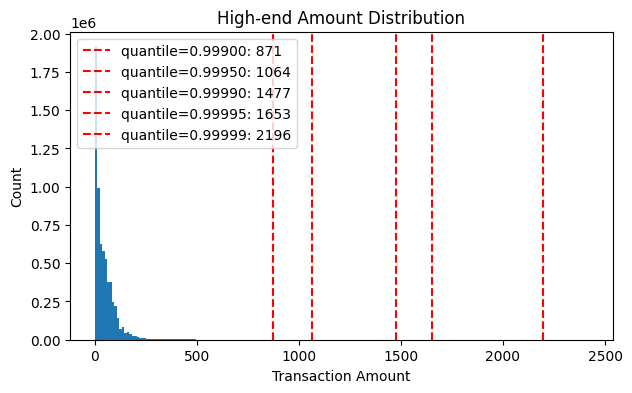

In [ ]:
#look at amount distribution
q = dfc["amount"].quantile([0.999, 0.9995, 0.9999, 0.99995, 0.99999]).round(2)
print(q)
#plot histogram of top end values
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
#plot from 0 to a bit above max tx amount
plt.hist(dfc["amount"], bins=200, range=(0, q.max()*1.1))
#for each quantile, plot red vertical line
for q, v in q.items():
    plt.axvline(v, color="red", linestyle="--", label=f"quantile={q:.5f}: {v:.0f}")
#set labels
plt.title("High-end Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.legend()
plt.show()

In [75]:
#list of candidate thresholds
candidates = sorted(set([
    1250, 1500, 1750, 2000, 2250
]))

#empty list to hold results
rows = []
total_tx = len(dfc)
#loop through each threshold
for cap in candidates:
    #instantiate amount cap object
    ac = AmountCap(cap=cap)
    #counter for flags and set for unique card ids
    flags = 0
    cards = set()
    #iterate through dataframe
    for row in dfc.itertuples():
        #raise flag if amount exceeds cap
        if ac.update(row.amount):
            flags += 1
            cards.add(row.card_id)
    #append results to rows list
    rows.append({
        "cap": cap,
        "flag_tx": flags,
        "tx_rate": flags/total_tx,
        "flag_cards": len(cards),
        "card_rate": len(cards)/dfc["card_id"].nunique()
    })

#sort by flagged transaction rate
pd.DataFrame(rows).sort_values("tx_rate")

,cap,flag_tx,tx_rate,flag_cards,card_rate
4,2250,62,0.000009,27,0.006642
3,2000,113,0.000016,43,0.010578
2,1750,250,0.000036,97,0.023862
1,1500,614,0.000089,206,0.050677
0,1250,1718,0.000250,509,0.125215


### Set Amount Cap

Based on the results, a cap of 1750 provides coverage of very high spends while the transaction flag rate is sufficiently low ( < 0.1% )

### Sweep Other Parameters

Test out a few values for alpha, k, initial (warm up) transactions, and minimum gates to find a combination that works best

In [ ]:
#alpha test values
alphas = [0.15, 0.2, 0.25]
#z score threshold
test_ks     = [4.5, 5, 5.25, 5.5]
#initial warm up values for transactions to see before scoring
inits  = [5, 10]
#set minimum gate values to test
gates = [100, 200, 250, 300]

#list to hold results
results = []
total_tx = len(dfc)
total_cards = dfc["card_id"].nunique()

#loop through each combination of parameters
for a in alphas:
    for test_k in test_ks:
        for i in inits:
            for gate in gates:
                #instantiate CardEWMA with current parameters
                cae = CardEWMA(alpha=a, k=test_k, initial=i, min_gate=gate)
                flags = 0
                cards = set()
                #iterate through dataframe
                for row in dfc.itertuples():
                    f, _ = cae.update(row.card_id, row.amount)
                    #if flag is raised, increment counter
                    if f:
                       flags += 1
                       cards.add(row.card_id)
                #append results to results list
                results.append({
                    "alpha": a, "k": test_k, "init": i,
                    "flag_tx": flags,
                    "tx_rate": flags/total_tx,
                   "flag_cards": len(cards),
                    "card_rate": len(cards)/total_cards,
                    "gate": gate
                })

#convert results to dataframe and sort
ewma_df = pd.DataFrame(results).sort_values(["tx_rate","card_rate","k","init","alpha"])
#inspect the first 10 rows
ewma_df.head(10)


,alpha,k,init,flag_tx,tx_rate,flag_cards,card_rate,gate
31,0.15,5.50,10,429,0.000063,298,0.073309,300
27,0.15,5.50,5,443,0.000065,309,0.076015,300
30,0.15,5.50,10,493,0.000072,327,0.080443,250
26,0.15,5.50,5,512,0.000075,342,0.084133,250
23,0.15,5.25,10,543,0.000079,374,0.092005,300
19,0.15,5.25,5,559,0.000081,386,0.094957,300
29,0.15,5.50,10,569,0.000083,361,0.088807,200
25,0.15,5.50,5,592,0.000086,379,0.093235,200
22,0.15,5.25,10,615,0.000090,404,0.099385,250
18,0.15,5.25,5,636,0.000093,420,0.103321,250


### Interpret Results and Set Parameters

Best results consistently used alpha = 0.15, so this will be chosen

k values of 5.25 and 5.5 keeps the rule quiet, 5.5 will rule out slightly more transactions so this will be the set value.

The results are sorted from lowest flag rate, the higher minimum gates naturally produce the least flags but also limit the rule to working in a smaller window. 250 will be set as the minimum gate to be a middle ground.

A larger warm up period is better so we get a stable baseline before scoring, therefore 10 will be used

Based on this we will set the parameters below

In [ ]:
#lock in params
CAP = 1750
ALPHA = 0.15
K = 5.5
INITIAL = 10
MIN_GATE = 250

## Location Based Rule

Try to detect 'impossible travel' by comparing the current tap to the previous one

- map zipcode to (latitude, longitude) using a lookup table.
- compute the haversine distance (distance on a sphere/globe) and time gap between taps 
- calculate the implied speed and flag if the result is over the set threshold

No ground truths here either so again use Caixa data to control false positives.

In [79]:
import importlib
import baseline_detector 

importlib.reload(baseline_detector)
from baseline_detector import ZipToCoord, ImpossibleTravel

#import zip code/lat/long file
zip_csv_path = "../data/raw/zip_lat_long.csv"
#instantiate ZipToCoord
z2c = ZipToCoord(zip_csv_path)

#instantiate ImpossibleTravel with initial params
it = ImpossibleTravel(zip_lookup=z2c, vmax_kmh=500.0, min_km=100.0, min_dt_s=30.0)

#decalre counters for flags, cards, and total tx
flags = 0
cards = set()
n = 0

#sort dataframe by card_id and timestamp, reset index to avoid multi-index issues
dfs = dfc.sort_values(["card_id", "timestamp"]).reset_index(drop=True)

#loop through dataset to count flags and unique cards
for row in dfs.sort_values("timestamp").itertuples():
    f, info = it.update(row.card_id, row.timestamp, zip_code=row.zip, lat=None, lon=None)
    n += 1
    if f:
        flags += 1
        cards.add(row.card_id)

#print results
print(f"ImpossibleTravel: {flags} tx flagged ({flags/n:.5%}); "
      f"distinct cards: {len(cards)} ({len(cards)/dfc['card_id'].nunique():.5%})")

ImpossibleTravel: 1158 tx flagged (0.01687%); distinct cards: 150 (3.69004%)


### Tuning Location Rule

Sweep a small grid of vmax_kmh, min_km, and min_dt_s on the Caixa dataset and report transaction flag rate and card flag rate. Based on the results we can adjust the perameters to those that are quietest while making sense

In [81]:
#set values to test for max speed, minimum distance, and minimum time delta
v_maxs   = [350, 400, 500]
min_kms  = [50, 75, 100]
min_dts  = [60, 90]

#find number of transactions and unique cards in the dataset
n_tx = len(dfc)
n_cards = dfc["card_id"].nunique()

#function to evaluate parameter combinations
def eval_combo(vmax, min_km, min_dt):
    #instantiate ImpossibleTravel with current parameters
    it = ImpossibleTravel(zip_lookup=z2c, vmax_kmh=vmax, min_km=min_km, min_dt_s=min_dt)
    #counter for flags and set for unique card ids
    flags = 0
    cards = set()
    #iterate through dataframe
    for row in dfs.itertuples():
        #add flag to counter if update returns True
        f, _ = it.update(row.card_id, row.timestamp, zip_code=row.zip)
        if f:
            flags += 1
            cards.add(row.card_id)
    #return a dictionary with the results
    return {
        "vmax_kmh": vmax,
        "min_km": min_km,
        "min_dt_s": min_dt,
        "flags": flags,
        #safe division to avoid division by zero
        "tx_rate": flags / n_tx if n_tx else 0.0,
        "card_rate": len(cards) / n_cards if n_cards else 0.0,
        "cards_flagged": len(cards),
    }

rows = []
#loop through each combination of parameters
for vmax in v_maxs:
    for mk in min_kms:
        for md in min_dts:
            rows.append(eval_combo(vmax, mk, md))

#sort results
sweep = pd.DataFrame(rows).sort_values(
    ["tx_rate", "card_rate", "min_km", "vmax_kmh", "min_dt_s"]
).reset_index(drop=True)
#look at first 10 rows
sweep.head(10)


,vmax_kmh,min_km,min_dt_s,flags,tx_rate,card_rate,cards_flagged
0,500,100,60,1115,0.000162,0.036900,150
1,500,100,90,1115,0.000162,0.036900,150
2,500,75,60,1144,0.000167,0.038622,157
3,500,75,90,1144,0.000167,0.038622,157
4,500,50,60,1189,0.000173,0.040098,163
5,500,50,90,1189,0.000173,0.040098,163
6,400,100,60,1278,0.000186,0.041574,169
7,400,100,90,1278,0.000186,0.041574,169
8,400,75,60,1312,0.000191,0.043788,178
9,400,75,90,1312,0.000191,0.043788,178


### Set Parameters

- the number of flags decreased as minimum distance increased which makes sense, we will use 150km as the value, it seems sensible
- the same was the case for max velocity. Any movement faster than any of these speeds would be suspicious so 500km/h will be used 
- the minimum time gap doesn't seem to affect teh results so 60s is fine.

In [114]:
#Set final parameters
V_MAX = 500
MIN_KM = 100
MIN_DT = 60

### Combine Rules

Combine the above rules to generate a single edge flag if any of the rules fire. 

Flag = Merchant Spike OR Card Burst OR Amount flag OR Location Flag

In [84]:
#import rule classes
importlib.reload(baseline_detector)
from baseline_detector import RuleCombiner, MerchantBaseline, CardBaseline, CardEWMA, AmountCap, ImpossibleTravel, MerchantWindow, CardWindow

#instantiate rule combiner to raise flag for any rule firing
comb = RuleCombiner(
    merchant_baseline=MerchantBaseline(threshold=THRESHOLD_M),
    card_baseline=CardBaseline(threshold=THRESHOLD_C),
    card_ewma=CardEWMA(alpha=ALPHA, k=K, initial=INITIAL, min_gate=MIN_GATE),
    amount_cap=AmountCap(cap=CAP),
    travel = ImpossibleTravel(zip_lookup=z2c, vmax_kmh=V_MAX, min_km=MIN_KM, min_dt_s=MIN_DT)
)

#counter for flags
edge_flag_count = 0

#iterate through sparkov + synthetic dataset
for row in df.itertuples():
    #get transaction data
    tx = {
        "timestamp": row.timestamp,
        "merchant_id": row.merchant_id,
        "card_id": row.card_id,
        "amount": getattr(row, "amount", 0.0),
        "zip": getattr(row, "zip", None),
        "city": getattr(row, "city", None),
    }
    #add flag to count if any rule fires
    if comb.update(tx):
        edge_flag_count += 1

#print total flags raised
print("Sparkov: total tx with edge_flag=1:", edge_flag_count)

Sparkov: total tx with edge_flag=1: 3859


In [116]:
#count for each rule individually to learn the distribution of flags between the rules

#create new rule instances
mb   = MerchantBaseline(threshold=THRESHOLD_M)
cb   = CardBaseline(threshold=THRESHOLD_C)
ac   = AmountCap(cap=CAP)
ce   = CardEWMA(alpha=ALPHA, k=K, initial=INITIAL, min_gate=MIN_GATE)
trav = ImpossibleTravel(zip_lookup=z2c, vmax_kmh=V_MAX, min_km=MIN_KM, min_dt_s=MIN_DT)

#dictionary to hold instances of rules firing
#keep values as sets so transactions can't be double counted
per_rule = {"merchant": set(), "card": set(), "cap": set(), "ewma": set(), "travel": set()}

#loop through dataset as tuples
for i, row in enumerate(df.itertuples(index=False)):
    #for each rule, test the row and add to count if flag is raised
    if mb.update(row.merchant_id, row.timestamp, row.card_id)[0]:
        per_rule["merchant"].add(i)
    if cb.update(row.card_id, row.timestamp, row.merchant_id)[0]:
        per_rule["card"].add(i)
    if ac.update(getattr(row, "amount", 0.0)):
        per_rule["cap"].add(i)
    if ce.update(row.card_id, getattr(row, "amount", 0.0))[0]:
        per_rule["ewma"].add(i)
    if trav.update(row.card_id, row.timestamp, zip_code=getattr(row, "zip", None))[0]:
        per_rule["travel"].add(i)

#print counts by rule
for k in ["merchant", "card", "cap", "ewma", "travel"]:
    print(f"{k}: {len(per_rule[k])}")

#flatten sets and get total count
edge_total = len({i for s in per_rule.values() for i in s})
print("edge_total:", edge_total)


merchant: 550
card: 179
cap: 1008
ewma: 2206
travel: 0
edge_total: 3859


### Results

The combined rules stay relatively quiet on the sparkov with a flag rate of ~0.2%, this includes the synthetic spikes which should all be flagged. The individual rules have all been tuned on the Caixa data so they are known to be quiet.

### Recap Final Parameter Values

In [87]:
print("THRESHOLD_M:", THRESHOLD_M, "THRESHOLD_C:", THRESHOLD_C)
print("CAP:", CAP, "EWMA:", {"alpha": ALPHA, "k": K, "initial": INITIAL, "min_gate": MIN_GATE})
print("Travel:", {"vmax": V_MAX, "min_km": MIN_KM, "min_dt": MIN_DT})


THRESHOLD_M: 6 THRESHOLD_C: 3
CAP: 1750 EWMA: {'alpha': 0.2, 'k': 5.25, 'initial': 10, 'min_gate': 250}
Travel: {'vmax': 400, 'min_km': 150, 'min_dt': 60}
